In [1]:
import numpy as np
from Snippets import Snippets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from Variational_Autoencoder_alla_Valerio import VAE
import os
from tensorflow import keras

In [2]:
subfolder = "4.0_256"
model_name = "VAE_Vocals_128D_17388samples_20Epochs"
num = 500
path = os.path.join("data_and_models", subfolder, model_name + "_song_order" + str(num) + ".npy")
song_orders = np.load(path, allow_pickle=True)
print("Model was trained with " + str(len(song_orders)) + " Songs")

Model was trained with 361 Songs


We can normalise the data and denormalise it later

In [3]:
flattened_orders = np.asarray([item for order in song_orders for item in order])
old_min = flattened_orders.min()
old_max = flattened_orders.max()
print("The minimum value in song_orders is: " + str(old_min))
print("The maximum value in song_orders is: " + str(old_max))


The minimum value in song_orders is: -6.5055714
The maximum value in song_orders is: 6.576535


In [4]:
norm_orders = Snippets._normalise(song_orders, 0, 1, old_min, old_max)

In [5]:
# # Add a end-token and the end of each song with value 0

# song_orders = []
# for song in norm_orders:
#     song = np.append(song, np.zeros(song.shape[1])).reshape(song.shape[0]+1, song.shape[1])
#     song_orders.append(song)

In [6]:
def generate_sequences(song_order, step: int, seq_length: int):
    X = []
    y = []
    for i in range(0, len(song_order) - seq_length, step):
        X.append(song_order[i:i+seq_length])
        y.append(song_order[i+seq_length])
    X = np.array(X)
    y = np.array(y)
    #y = y.reshape(y.shape[0], 1, y.shape[1])
    return X,y

In [7]:
x_data = []
y_data = []

for song in norm_orders:
    X_song, y_song = generate_sequences(song, step=1, seq_length=4)
    x_data.extend(X_song)
    y_data.extend(y_song)

x_data = np.array(x_data)
y_data = np.array(y_data)

print("X of one song: ", X_song.shape, "\ty of one song: ", y_song.shape)
print("X of all songs: ", x_data.shape, "\ty of all songs: ", y_data.shape)

X of one song:  (55, 4, 128) 	y of one song:  (55, 128)
X of all songs:  (20012, 4, 128) 	y of all songs:  (20012, 128)


In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1)

In [9]:
from tensorflow.keras.layers import Embedding, LSTM, Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError


# n_units = 256
# embedding_size = 150

# order_in = Input(shape=(x_train.shape[1], x_train.shape[2]))
# #x = Embedding(128, embedding_size,)(order_in)
# x = LSTM(n_units)(order_in)
# # x = layers.Dropout(0.2)(x)
# order_out = Dense(128, activation='softmax')(x)

# char_model = Model(order_in, order_out, name="char_rnn")

# char_model.compile(
#     # note that we use the same loss as with MNIST
#     # which is used when we want to learn a
#     # probability distribution
#     loss=MeanSquaredError,
#     optimizer=Adam(learning_rate=0.001)
# )

# char_model.summary()

# model = Sequential()
# model.add(LSTM((256), batch_input_shape=(None,None,128), return_sequences=True))
# model.add(LSTM((128), return_sequences=False))
# model.compile(loss='mean_squared_error', optimizer='Adam')

model = Sequential()
model.add(LSTM((256), input_shape=(None,128), return_sequences=True))
model.add(LSTM(256))
model.add(Dense(128, activation="relu"))
optimiser = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='mean_squared_error', optimizer=optimiser)

2022-04-17 13:39:54.371750: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
history = model.fit(x_train, y_train, epochs=100, batch_size=128, shuffle=True, validation_data=(x_test,y_test))

Train on 18010 samples, validate on 2002 samples
Epoch 1/100
17792/18010 [============================>.] - ETA: 0s - loss: 0.0644

/Users/dearvr-Tester/Documents/MetaHuman/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


18010/18010 [==============================] - 4s 242us/sample - loss: 0.0643 - val_loss: 0.0591
Epoch 2/100
18010/18010 [==============================] - 3s 192us/sample - loss: 0.0587 - val_loss: 0.0570
Epoch 3/100
18010/18010 [==============================] - 3s 191us/sample - loss: 0.0550 - val_loss: 0.0508
Epoch 4/100
18010/18010 [==============================] - 3s 184us/sample - loss: 0.0507 - val_loss: 0.0508
Epoch 5/100
18010/18010 [==============================] - 3s 183us/sample - loss: 0.0506 - val_loss: 0.0506
Epoch 6/100
18010/18010 [==============================] - 4s 195us/sample - loss: 0.0506 - val_loss: 0.0506
Epoch 7/100
18010/18010 [==============================] - 3s 194us/sample - loss: 0.0505 - val_loss: 0.0506
Epoch 8/100
18010/18010 [==============================] - 3s 185us/sample - loss: 0.0505 - val_loss: 0.0505
Epoch 9/100
18010/18010 [==============================] - 4s 194us/sample - loss: 0.0505 - val_loss: 0.0505
Epoch 10/100
18010/18010 [=====

In [11]:
path = os.path.join("data_and_models", subfolder, model_name + "_ML2_LTSM")
model.save(path)

2022-04-17 13:45:55.602086: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: data_and_models/4.0_256/VAE_Vocals_128D_17388samples_20Epochs_ML2_LTSM/assets


In [12]:
short = x_test[0][:150]
results = model.predict(short.reshape(1,short.shape[0],short.shape[1]))

/Users/dearvr-Tester/Documents/MetaHuman/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [13]:
np.mean(abs(Snippets._denormalise(results[0], 0, 1, old_min, old_max) - Snippets._denormalise(y_test[0], 0, 1, old_min, old_max)))

0.9756221

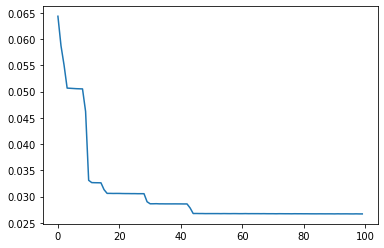

In [14]:
plt.plot(history.history['loss'])

## Test Reconstruction

In [5]:
path = os.path.join("data_and_models", subfolder, model_name + "_ML2_LTSM")
model = keras.models.load_model(path)

2022-04-17 13:54:59.233133: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
def generate_order(model, seed, target_length):
    needed_coordinates = target_length - len(seed)
    seed = seed.reshape(1,seed.shape[0],seed.shape[1])
    for i in range(needed_coordinates):
        next_coordinate = model.predict(seed)
        next_coordinate = next_coordinate.reshape(1, next_coordinate.shape[0], next_coordinate.shape[1])
        seed = np.append(seed, next_coordinate, axis=1)
        print(f"reconstructed {i+1} of {needed_coordinates} coordinates", end='\r')
    output_order = seed.reshape(seed.shape[1], seed.shape[2])
    return seed

In [7]:
original = song_orders[0]
seed = original[:4]
reconstructed = generate_order(model, seed, len(original))


/Users/dearvr-Tester/Documents/MetaHuman/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [8]:
reconstructed = reconstructed.reshape(reconstructed.shape[1], reconstructed.shape[2])

In [9]:
# original = Snippets._denormalise(original, 0, 1, old_min, old_max)
#reconstructed = Snippets._denormalise(reconstructed, 0, 1, old_min, old_max)

This is the original


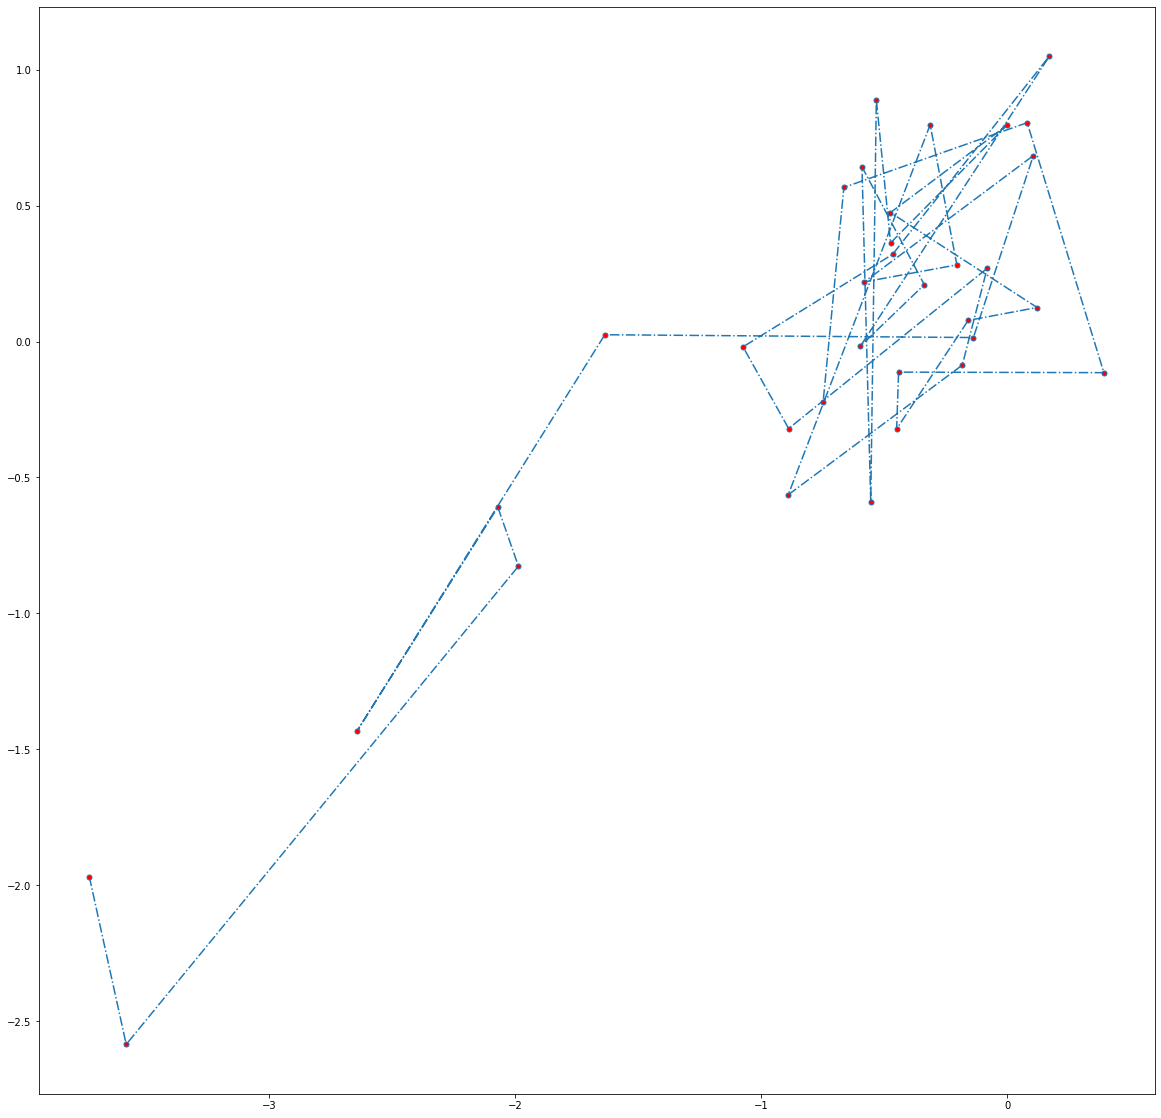

In [10]:
print("This is the original")
plt.figure(figsize=(20,20))
plt.plot(original[:, 0], original[:, 1], '-.o', markersize=5, markerfacecolor='red')
plt.show()


This is the reconstruction


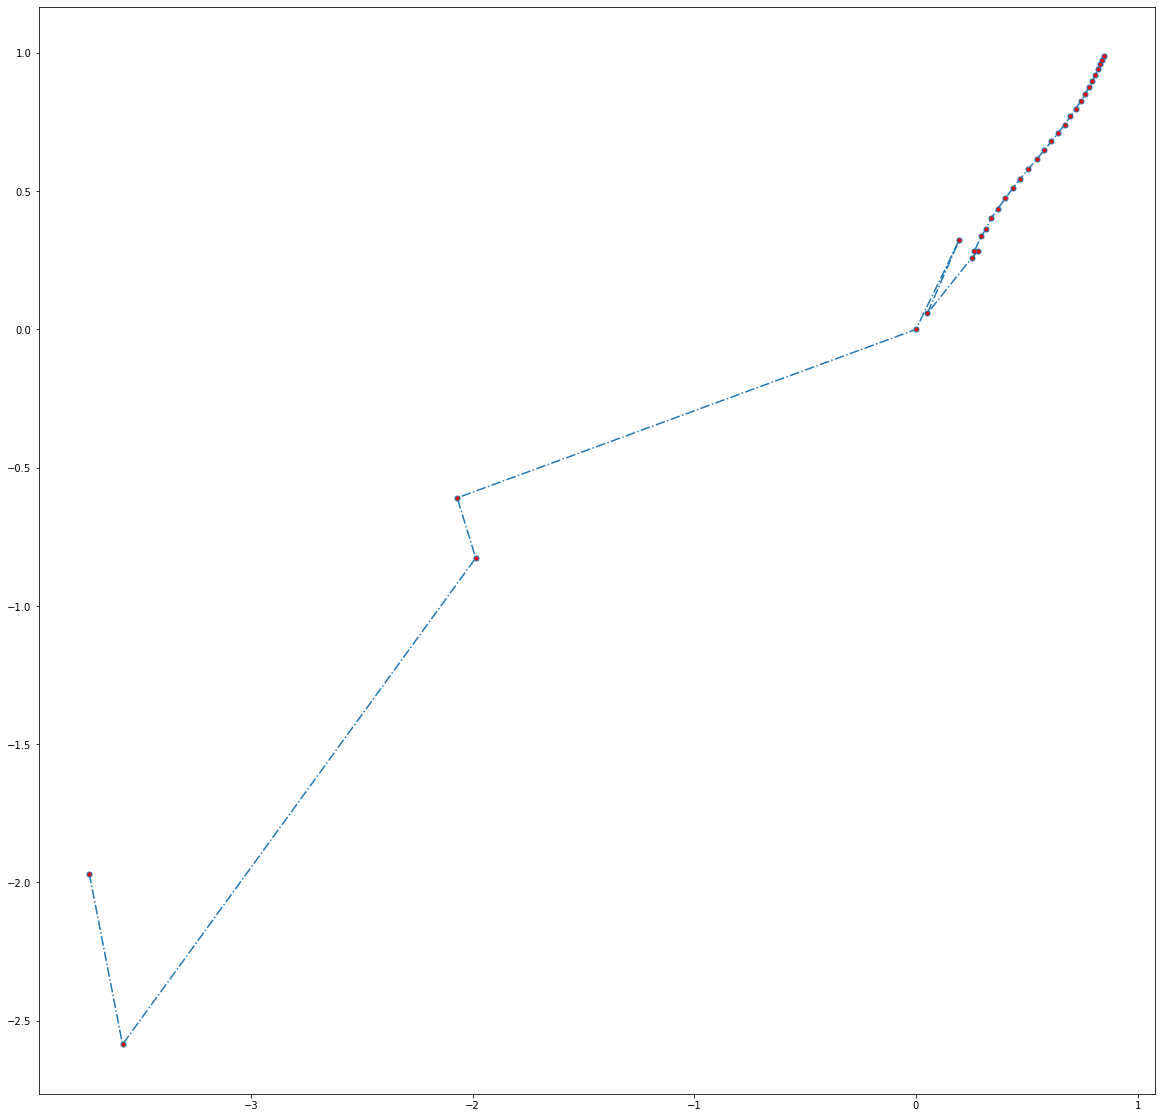

In [11]:
print("This is the reconstruction")
plt.figure(figsize=(20,20))
plt.plot(reconstructed[:, 0], reconstructed[:, 1], '-.o', markersize=5, markerfacecolor='red')
plt.show()

In [12]:
WIN_LENGTH = 690*2
HOP_LENGTH = 690
N_FFT = 690*2

path = os.path.join("data_and_models", subfolder, model_name)
snippet_autoencoder = VAE.load(path)

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
reconstructed_signal, reconstructed_spectos = Snippets.latent_representation_to_pcm(latent_representations=reconstructed,
                                                                                    model=snippet_autoencoder, 
                                                                                    hop_length=HOP_LENGTH, 
                                                                                    n_fft=N_FFT, 
                                                                                    win_length=WIN_LENGTH)

Getting latent representation of the spectos...


/Users/dearvr-Tester/Documents/MetaHuman/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Getting PCM from spectos...


max: 0.18778539
min: 1e-10
mean: 0.000834618
Start Transform


TypeError: mel() got multiple values for keyword argument 'n_mels'

In [ ]:
display(Audio(reconstructed_signal, rate=44100))

In [ ]:
folder_path = os.path.join('demo_data', 'stems')
paths = librosa.util.find_files(folder_path, ext=['wav'])
original_song, _ = librosa.load(paths[song_num],sr=44100, mono=True)

print("This is the original song: \n")
display(Audio(original_song, rate=44100))
